In [1]:
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, LeakyReLU
from tensorflow.keras.layers import LeakyReLU, concatenate
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import fashion_mnist
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

In [7]:
img_shape = (28, 28, 1)
opt = Adam(lr=0.0002)
latent_dim = 128

In [8]:
def create_generator():
  inp = Input(shape=(latent_dim, ))
  d = Dense(7*7*256)(inp)
  d = LeakyReLU()(d)

  d = Reshape((7, 7, 256))(d)

  d = Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same')(d)
  d = BatchNormalization()(d)
  d = LeakyReLU()(d)

  d = Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same')(d)
  d = BatchNormalization()(d)
  d = LeakyReLU()(d)

  d = Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', activation='tanh')(d)

  model = Model(inp, d, name='generator')

  return model

In [9]:
def create_discriminator(img_shape=(28, 28, 1)):
  z = Input(shape=(latent_dim,))
  img = Input(shape=img_shape)

  img_nn = Conv2D(64, (5, 5), strides=(2, 2), padding='same')(img)
  img_nn = LeakyReLU()(img_nn)

  img_nn = Conv2D(128, (5, 5), strides=(2, 2), padding='same')(img_nn)
  img_nn = LeakyReLU()(img_nn)

  img_f = Flatten()(img_nn)

  z_nn = Dense(512)(z)
  z_nn = LeakyReLU()(z_nn)

  nn = concatenate([img_f, z_nn])

  nn = Dense(1, activation='sigmoid')(nn)

  return Model([img, z], nn, name='discriminator')

In [10]:
def create_encoder(image_shape=(28, 28, 1)):
  inp = Input(shape=image_shape)

  d = Conv2D(512, (5, 5), strides=(2, 2))(inp)
  d = BatchNormalization()(d)
  d = LeakyReLU()(d)

  d = Conv2D(512, (5, 5), strides=(2, 2))(d)
  d = BatchNormalization()(d)
  d = LeakyReLU()(d)

  d = Flatten()(d)
  d = Dense(latent_dim)(d)
  model = Model(inp, d, name='encoder')
  return model

In [12]:
def define_generator():
  model = Sequential()
  model.add(Dense(512, input_dim=latent_dim))
  model.add(LeakyReLU())
  model.add(BatchNormalization())

  model.add(Dense(512))
  model.add(LeakyReLU())
  model.add(BatchNormalization())

  model.add(Dense(np.prod(img_shape), activation='tanh'))
  model.add(Reshape(img_shape))

  z = Input(shape=(latent_dim, ))
  gen_img = model(z)

  return Model(z, gen_img)

In [13]:
def define_discriminator():
  z = Input(shape=(latent_dim,))
  img = Input(shape=img_shape)

  inp = concatenate([z, Flatten()(img)])

  d = Dense(1024)(inp)
  d = LeakyReLU()(d)
  d = Dropout(0.5)(d)

  d = Dense(1024)(d)
  d = LeakyReLU()(d)
  d = Dropout(0.5)(d)

  d = Dense(1024)(d)
  d = LeakyReLU()(d)
  d = Dropout(0.5)(d) 
  
  out = Dense(1, activation='sigmoid')(d)

  return Model([z, img], out)

In [14]:
def define_encoder():
  model = Sequential([Flatten(input_shape=img_shape),
                      Dense(128),
                      LeakyReLU(),
                      BatchNormalization(),

                      Dense(256),
                      LeakyReLU(),
                      BatchNormalization(),
                      
                      Dense(512),
                      LeakyReLU(),
                      BatchNormalization(),
                      Dense(latent_dim)])

  img = Input(shape=img_shape)
  z = model(img)

  return Model(img, z)

In [16]:
discriminator = define_discriminator()
discriminator.compile(loss=['binary_crossentropy'], optimizer=opt, metrics=['accuracy'])

discriminator.trainable = False

generator = define_generator()
encoder = define_encoder()

z = Input(shape=(latent_dim,))
img_ = generator(z)

img = Input(shape=img_shape)
z_ = encoder(img)

fake = discriminator([z, img_])
real = discriminator([z_, img])

bigan_generator = Model([z, img], [fake, real])
bigan_generator.compile(loss=['binary_crossentropy', 'binary_crossentropy'], optimizer=opt)

In [17]:
def train(dataset, epochs, batch_size=128):
  (X_train, _), (_, _) = dataset.load_data()
  X_train = (X_train.astype(np.float32) - 127.5) / 127.5
  X_train = np.expand_dims(X_train, axis=3)

  real = np.ones((batch_size, 1))
  fake = np.zeros((batch_size, 1))

  for epoch in range(epochs):
    z = np.random.normal(size=(batch_size, latent_dim))
    imgs_ = generator.predict(z)

    idx = np.random.randint(0, X_train.shape[0], batch_size)
    imgs = X_train[idx]
    z_ = encoder.predict(imgs)

    d_loss_real = discriminator.train_on_batch([z_, imgs], real)
    d_loss_fake = discriminator.train_on_batch([z, imgs_], fake)
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

    g_loss = bigan_generator.train_on_batch([z, imgs], [real, fake])

    print(f"Epoch {epoch+1}")

In [ ]:
train(fashion_mnist, 100, 1)

In [23]:
def plot_images():
  row, col = 2, 3

  z = np.random.normal(size=(6, latent_dim))
  images = generator.predict(z)
  images = 0.5 * images + 0.5
  
  fig, axs = plt.subplots(row, col, figsize=(16, 6))
  count = 0
  for i in range(row):
    for j in range(col):
      axs[i, j].imshow(images[count, :, :, 0], cmap='gray')
      axs[i, j].axis('off')
      count += 1

  plt.show()

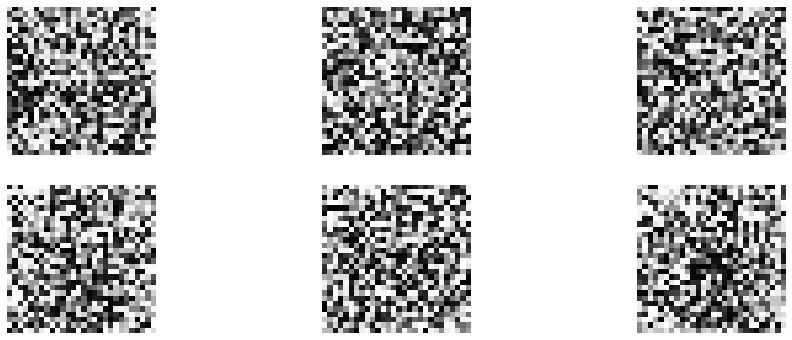

In [24]:
plot_images()